# Iterative methods for the numerical solution of linear systems

With iterative methods, the numerical solution of the linear system $Ax = b$ is obtained as the limit of a sequence of solutions $x^{(k)}$ of simpler linear systems. 

While direct methods proceed by algebraic transformations of the initial matrix, and are therefore exact modulo finite-precision arithmetic, iterative method imply necessarily a _truncation error_.
On the other hand, iterative method preserve the sparsity of the matrix, an are therefore much more efficient when dealing large sparse systems (i.e. most of the times...).


## General scheme of iterative methods

Given a matrix $A \in \mathbb{R}^{n\times n}$, we consider a decomposition of the form 
$$
A = P - (P - A) ,
$$
hence 
$$
Ax = b \iff Px = (P-A)x + b
$$
so that it makes sense to define the iterative scheme as
$$
x^{(k+1)} = B x^{(k)} + g 
$$
with $B = P^{-1}(P-A)$ and $g = P^{-1} b$.

### Conditions for the convergence of an iterative method

__Definition:__
An iterative method is said to be _convergent_ if for any initial condition $x^{(0)} \in \mathbb{R}^n$, the sequence $\{x^{(k)}\}_{k \in \mathbb{N}}$ is convergent.

__Theorem:__ 
Necessary and sufficient condition for the convergence of an iterative method is that the _spectral radius_ of the iteration matrix $B$ is strictly less than $1$: 
$$ \rho(B) < 1. $$

__Definition:__
The _spectral radius_ of a matrix $B$ is defined as 
$$
\rho(B) = \max_i\vert \lambda_i\vert,
$$
where $\lambda_i$ are the eigenvalues of $B$.

### Stopping conditions for iterative methods

Given a tolerance $\epsilon$, one can use different stopping criteria:
- Step difference: $\Vert x^{(k+1)} - x^{(k)}\Vert < \epsilon$
- Relative step difference: $\frac{\Vert x^{(k+1)} - x^{(k)}\Vert}{x^{(k)}} < \epsilon$
Having defined the _residual_ at step $k$ as $r^{(k)} = A x^{(k)} - b$,
- Residual norm: $\Vert r^{(k)} \Vert < \epsilon$
- Relative residual norm: $\frac{\Vert r^{(k)}\Vert}{\Vert b\Vert}  < \epsilon$


## Jacobi method

If the diagonal elements of $A$ are not zero, we can consider 
$$
P = D = (a_{ii})_{i=1}^{n}, 
$$
so that the corresponding iterative method becomes:
$$
x^{(k+1)} = D^{-1} b - D^{-1} (A - D)x^{k},
$$
or by components
$$
x_i^{(k+1)} = \frac{1}{a_{ii}} \left[b_i - \sum_{\substack{j=1 \\ j\neq i}}^{n} a_{ij}x_j^{(k)}\right] 
= \frac{1}{a_{ii}} \left[b_i - \sum_{j=1}^{i-1} a_{ij}x_j^{(k)} - \sum_{j=i+1}^{n} a_{ij}x_j^{(k)}\right] ,\quad i = 1,\ldots, n,
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
A = np.arange(1, 17).reshape(4, 4)
D = np.diag(np.diag(A))
E = - np.tril(A, -1)
F = - np.triu(A, 1)

B_J = np.linalg.inv(D) @ (E + F)
B_J

array([[ 0.        , -2.        , -3.        , -4.        ],
       [-0.83333333,  0.        , -1.16666667, -1.33333333],
       [-0.81818182, -0.90909091,  0.        , -1.09090909],
       [-0.8125    , -0.875     , -0.9375    ,  0.        ]])

We can check the spectral radius

In [3]:
rho_B_J = max(abs(np.linalg.eigvals(B_J)))
print(rho_B_J)

3.9361900689860168


It is not difficult to see that this is tru every time the system matrix $A$ is singular.

Let us now define a function to perform the Jacobi method:

In [4]:
def jacobi(A, b, tol=1e-10, max_iter=100):
	"""
	Solves the system of linear equations Ax = b using the Jacobi method.
	Stopping criterion based on 2-norm of residual.
	
	Parameters:
	A: Coefficient matrix (must be square).
	b: Right-hand side vector.
	tol (optional): Tolerance for the stopping criterion. Defaults to 1e-10.
	max_iter (optional): Maximum number of iterations. Defaults to 100.
	
	Returns:
	Solution vector x, iteration count.
	"""

	try:	
		n, m = A.shape
	except:
		raise ValueError("Input must be a 2D array (matrix).")
	
	assert n == m, "Matrix A must be square."
	assert n == len(b), "Matrix A and vector b must have the same number of rows."

	x = np.zeros(n)
	x_new = np.zeros(n)

	iter = 0 
	res = tol + 1
	while iter < max_iter and res > tol:
		for i in range(n):
			x_new[i] = (b[i] - np.dot(A[i, :i], x[:i]) - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]

		x = x_new.copy()
		res = np.linalg.norm(np.dot(A, x) - b, 2)
		iter += 1
	
	return x, iter

### Example

In [5]:
# Generate a NxN system
N = 5
# np.random.seed(0)  # For reproducibility
A = np.random.rand(N, N) + np.eye(N) 
x_exact = np.random.rand(N)
b = A@x_exact

# Solve the system using Jacobi
x, iter = jacobi(A, b, tol=1e-10, max_iter=100)

# Compare the solution with the exact solution
print("Found solution in ", iter, " iterations.")
print("Relative error: ", np.linalg.norm(x - x_exact, 2)/np.linalg.norm(x_exact, 2))

Found solution in  100  iterations.
Relative error:  437363094047601.94


## Gauss-Seidel method

Looking back at the Jacobi iteration, we see that at the $i$-th row we already have $x^{(k+1)}_{j}$ for $j=1,\ldots,i-1$, so we can use those results:
$$
x_i^{(k+1)} = \frac{1}{a_{ii}} \left[b_i - \sum_{j=1}^{i-1} a_{ij}x_j^{(k+1)} - \sum_{j=i+1}^{n} a_{ij}x_j^{(k)}\right] ,\quad i = 1,\ldots, n,
$$

In [6]:
def gauss_seidel(A, b, tol=1e-10, max_iter=100):
	"""
	Solves the system of linear equations Ax = b using the Gauss-Seidel method.
	Stopping criterion based on 2-norm of residual.
	"""

	try:	
		n, m = A.shape
	except:
		raise ValueError("Input must be a 2D array (matrix).")
	
	assert n == m, "Matrix A must be square."
	assert n == len(b), "Matrix A and vector b must have the same number of rows."

	x = np.zeros(n)
	x_new = np.zeros(n)

	iter = 0 
	res = tol + 1
	while iter < max_iter and res > tol:
		for i in range(n):
			x_new[i] = (b[i] - np.dot(A[i, :i], x_new[:i]) - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]

		x = x_new.copy()
		res = np.linalg.norm(np.dot(A, x) - b, 2)
		iter += 1
	
	return x, iter


### Example

In [7]:
# Solve the system using Gauss-Seidel
x, iter = gauss_seidel(A, b)

# Compare the solution with the exact solution
print("Found solution in ", iter, " iterations.")
print("Relative error: ", np.linalg.norm(x - x_exact, 2)/np.linalg.norm(x_exact, 2))

Found solution in  29  iterations.
Relative error:  3.128911717720405e-11


## Comparison between Jacobi and Gauss-Seidel

Let u s compare the spectral radius of the iteration matrices for the two methods

In [8]:
A = np.array([[3, 0, 4], [7, 4, 2], [-1, -1, -2]])
D = np.diag(np.diag(A))
E = - np.tril(A, -1)
F = - np.triu(A, 1)

B_J = np.linalg.inv(D) @ (E + F)
B_GS = np.linalg.inv(D - E) @ F

print("Spectral radius of B_J: ", max(abs(np.linalg.eigvals(B_J))))
print("Spectral radius of B_GS: ", max(abs(np.linalg.eigvals(B_GS))))

Spectral radius of B_J:  1.3375103871875085
Spectral radius of B_GS:  0.2500000000000001


In [9]:
A = np.random.rand(5, 5) + np.eye(5)
D = np.diag(np.diag(A))
E = - np.tril(A, -1)
F = - np.triu(A, 1)

B_J = np.linalg.inv(D) @ (E + F)
B_GS = np.linalg.inv(D - E) @ F

print("Spectral radius of B_J: ", max(abs(np.linalg.eigvals(B_J))))
print("Spectral radius of B_GS: ", max(abs(np.linalg.eigvals(B_GS))))

Spectral radius of B_J:  1.3343986971630608
Spectral radius of B_GS:  0.33145974658240557


In [10]:
A = np.array([[-3, 3, -6], [-4, 7, -8], [5, 7, -9]])
D = np.diag(np.diag(A))
E = - np.tril(A, -1)
F = - np.triu(A, 1)

B_J = np.linalg.inv(D) @ (E + F)
B_GS = np.linalg.inv(D - E) @ F

print("Spectral radius of B_J: ", max(abs(np.linalg.eigvals(B_J))))
print("Spectral radius of B_GS: ", max(abs(np.linalg.eigvals(B_GS))))

Spectral radius of B_J:  0.8133091054692767
Spectral radius of B_GS:  1.1111111111111107


__Theorem__
Let $A$ be a _tridiagonal_ matrix of order $n$ with principal elements $\neq 0$. Then Gauss-Seidel method converges $\iff$ Jacobi method converges and in particular
$$
\rho(B_\text{GS}) = \rho(B_\text{J})^2,
$$
so that in this conditions Gauss-Seidel is twice as fast.

In [11]:
N = 100
A = 2*np.eye(N) + np.diag(-np.ones(N-1), -1) + np.diag(-np.ones(N-1), 1)

D = np.diag(np.diag(A))
E = - np.tril(A, -1)
F = - np.triu(A, 1)

B_J = np.linalg.inv(D) @ (E + F)
B_GS = np.linalg.inv(D - E) @ F

print("Spectral radius of B_J: ", max(abs(np.linalg.eigvals(B_J))))
print("Spectral radius of B_GS: ", max(abs(np.linalg.eigvals(B_GS))))

Spectral radius of B_J:  0.9995162822919921
Spectral radius of B_GS:  0.9990327985667966


## Richardson methods

Starting again from the decomposition $A = P - (P-A)$, we can note that $Ax = b \iff Px = (P-A)x + b$, which defines the iteration $Px^{(k+1)} = (P-A)x^{(k)} + b$, so that 
$$
P(x^{(k+1)} - x^{(k)}) = r^{(k)}, 
$$
which ca ben further generalized introducing an acceleration parameter $\alpha_k$ at each iteration:
$$
P(x^{(k+1)} - x^{(k)}) = \alpha_k r^{(k)} \iff x^{(k+1)} = x^{(k)} +  \alpha_k P^{-1} r^{(k)}. 
$$
This is in general called preconditioned Richardson's method and it can be 
- stationary, if $\alpha_k = \alpha $; or 
- dynamic if the step-size varies at each iteration.

__Observation__ 
For $\alpha=1$, we find the previous methods by setting 
- $P = D$, we get Jacobi,
- $P = D-E$, we get Gauss-Seidel.

### Stationary preconditioned Richardson method

The iteration matrix for the stationary preconditioned Richardson method is 
$$
R_\alpha = I - \alpha P^{-1} A,
$$ 
and its eigenvalues are
$$
1 - \alpha \eta_i
$$,
being $\eta_i$ the eigenvalues of $P^{-1} A$.


If $A$ is symmetric and positive definite, one can see that the optima value for the acceleration parameter is
$$
\alpha^* = \frac{2}{\eta_{\max} + \eta_{\min}}, 
$$
for which 
$$
\rho(R_\alpha) = \frac{\eta_{\max} - \eta_{\min}}{\eta_{\max} + \eta_{\min}}.
$$

In [12]:
def richardson(A, b, P=None, alpha=None, tol=1e-10, max_iter=100):
	"""
	Solves the system of linear equations Ax = b using the Richardson method.
	
	Parameters:
	A: Coefficient matrix (must be symmetric and positive definite).
	b: Right-hand side vector.
	P (optional): Preconditioner matrix. Defaults to the identity matrix.
	alpha (optional): Relaxation parameter. If None, it will be set to the optimal value.
	tol (optional): Tolerance for the stopping criterion. Defaults to 1e-10.
	max_iter (optional): Maximum number of iterations. Defaults to 100.
	
	Returns:
	Solution vector x, iteration count.
	"""
	
	n, m = A.shape
	assert n == m, "Matrix A must be square."
	assert n == len(b), "Matrix A and vector b must have the same number of rows."
	assert np.allclose(A, A.T), "Matrix A must be symmetric."
	
	if P is None:
		P = np.eye(n)
	
	if alpha is None:
		eigvals = np.linalg.eigvals(np.linalg.inv(P) @ A)
		alpha = 2 / (np.max(eigvals) + np.min(eigvals))
	
	x = np.zeros(n)
	r = b - A @ x
	
	iter = 0
	res = tol + 1

	while iter < max_iter and res > tol:
		z = np.linalg.solve(P, r)
		x += alpha * z
		r -= alpha * A @ z
		res = np.linalg.norm(r, 2)
		iter += 1

	return x, iter

### Preconditioned gradient method

We can chose $\alpha_k$ so to minimize the square of the error at step $k+1$ in the norm induced bu $A$, which we denote by 
$$
\Vert e^{(k+1)} \Vert_A ^2 = (e^{(k+1)}, e^{(k+1)})_A =  (A e^{(k+1)}, e^{(k+1)}).
$$
Noting that 
$$
A (x^* - x^{(k+1)}) = b - A x^{(k+1)} = r^{(k+1)},
$$
and we can look for the optimal $\alpha_k$ by stationarity of $(r^{(k+1)}, e^{(k+1)})$, which turns out to be 
$$
\alpha_k = \frac{(z^{(k)}, r^{(k)})}{(A z^{(k)}, z^{(k)})},
$$
where $z^{(k)} = P^{-1} r^{(k)}$ is the preconditioned residual. 

In [13]:
def gradient(A, b, x0 = None, P=None, alpha=None, tol=1e-10, max_iter=100):
	"""
	Solves the system of linear equations Ax = b using the gradient method.
	
	Parameters:
	A: Coefficient matrix (must be symmetric and positive definite).
	b: Right-hand side vector.
	P (optional): Preconditioner matrix. Defaults to the identity matrix.
	tol (optional): Tolerance for the stopping criterion. Defaults to 1e-10.
	max_iter (optional): Maximum number of iterations. Defaults to 100.
	
	Returns:
	Solution vector x, iteration count.
	"""
	
	n, m = A.shape
	assert n == m, "Matrix A must be square."
	assert n == len(b), "Matrix A and vector b must have the same number of rows."
	assert np.allclose(A, A.T), "Matrix A must be symmetric."
	
	if x0 is None:
		x = np.zeros(n)
	else:
		x = x0.copy()

	if P is None:
		P = np.eye(n)
	
	r = b - A @ x
	
	iter = 0
	res = tol + 1

	while iter < max_iter and res > tol:
		z = np.linalg.solve(P, r)
		Az = A@z
		alpha = np.dot(z,r)/np.dot(z,Az)
		x += alpha * z
		r -= alpha * Az
		res = np.linalg.norm(r, 2)
		iter += 1
		
	return x, iter


## Conjugate Gradient (CG)

In the gradient method, step $k+1$ is taken in the direction of $z^{(k)}$ and the step has length $\alpha_k$ that minimizes $\Vert e^{(k+1)}\Vert_A^2$.
In the conjugate gradient method, the idea is to take the $k+1$-th step in a direction $p^{(k)} = r^{(k)} + \beta_k p^{(k-1)}$, with the parameter $\beta_k$ chosen to minimize $\Vert e^{(k)}\Vert_A^2$. The choice turns out to be 
$$
\beta_k = - \frac{(A p^{(k-1)},r^{(k)})}{(A p^{(k-1)},p^{(k-1)})}.
$$
With this choice, $(A p^{(k)},p^{(k-1)}) = 0$, meaning that two subsequent descent directions are orthogonal in the scalar product induced by $A$, in other words successive steps are more independent. 

__Algorithm by Hestenes & Stiefel (1952)__

First we note that 
- $(r^{(k)},p^{(k)}) = (r^{(k)},r^{(k)} + \beta_k p^{k-1}) = \Vert r^{(k)} \Vert^2$
- $(A p^{(k-1)},p^{(k-1)}) = \frac{1}{\alpha_{k-1}} (r^{(k-1)},p^{(k-1)}) =  \frac{ \Vert r^{(k-1)} \Vert^2}{\alpha_{k-1}}$
- $(A p^{(k-1)},r^{(k)}) = \frac{1}{\alpha_{k-1}} (A (x^{(k)} - x^{k-1})  ,r^{(k)}) = \frac{1}{\alpha_{k-1}} (r^{(k)} - r^{k-1},r^{(k)}) =  \frac{\Vert r^{(k)} \Vert^2}{\alpha_{k-1}} $.

Therefore we write 
$$
\alpha_k = \frac{\Vert r^{(k)} \Vert^2}{(A p^{(k)}, p^{(k)})},\quad 
\beta_k = \frac{\Vert r^{(k)} \Vert^2}{\Vert r^{(k-1)} \Vert^2}
$$

In [14]:
def conj_gradient(A, b, x0 = None, tol=1e-10, max_iter=100):
	"""
	Solves the system of linear equations Ax = b using the Conjugate Gradient method.
	
	Parameters:
	A: Coefficient matrix (must be symmetric and positive definite).
	b: Right-hand side vector.
	P (optional): Preconditioner matrix. Defaults to the identity matrix.
	tol (optional): Tolerance for the stopping criterion. Defaults to 1e-10.
	max_iter (optional): Maximum number of iterations. Defaults to 100.
	
	Returns:
	Solution vector x, iteration count.
	"""
	
	n, m = A.shape
	assert n == m, "Matrix A must be square."
	assert n == len(b), "Matrix A and vector b must have the same number of rows."
	assert np.allclose(A, A.T), "Matrix A must be symmetric."
	
	if x0 is None:
		x = np.zeros(n)
	else:
		x = x0.copy()
		 
	r = b - A @ x
	p = r.copy()
	
	iter = 0
	res = tol + 1

	while iter < max_iter and res > tol:
		rho = np.dot(r,r)
		Ap = A @ p
		alpha =  rho / np.dot(Ap,p)

		x += alpha * p
		r -= alpha * Ap

		rho_new = np.dot(r, r)
		beta = rho_new / rho
		rho = rho_new
		p = r + beta * p

		res = np.linalg.norm(r, 2)
		iter += 1
		
	return x, iter

## Complete comparison

In [15]:
# define discretization
n = 30
h = 1/(n-1)

x = np.linspace(0,1,n)

# System matrix A
a = -np.ones((n-1))
b = 2*np.ones((n))
A = (1/h**2)*(np.diag(a,-1)+np.diag(b)+np.diag(a,1))

# Boundary conditions
A[0,:] = 0
A[:,0] = 0
A[0,0] = 1

A[-1,:] = 0
A[:,-1] = 0
A[-1,-1] = 1

# Forcing term
f = x*(1.-x)

# Exact solution
u_ex = (x**4)/12. - (x**3)/6. + x/12.
# u_ex = np.linalg.solve(A,f)
 
# f = A@u_ex


In [16]:
sol_jacobi = jacobi(A, f, tol=1e-10, max_iter=10000)
print(f"Jacobi converged in {sol_jacobi[1]}. Relative error {np.linalg.norm(sol_jacobi[0] - u_ex, 2)/np.linalg.norm(u_ex, 2)}.")

sol_gs = gauss_seidel(A, f, tol=1e-10, max_iter=10000)
print(f"Gauss-Seidel converged in {sol_gs[1]}. Relative error {np.linalg.norm(sol_gs[0] - u_ex, 2)/np.linalg.norm(u_ex, 2)}.")

sol_spr = richardson(A, f,tol=1e-10, max_iter=10000)
print(f"Stationary Richardson converged in {sol_spr[1]}. Relative error {np.linalg.norm(sol_spr[0] - u_ex, 2)/np.linalg.norm(u_ex, 2)}.")

sol_sd = gradient(A, f, tol=1e-10, max_iter=10000)
print(f"Gradient converged in {sol_sd[1]}. Relative error {np.linalg.norm(sol_sd[0] - u_ex, 2)/np.linalg.norm(u_ex, 2)}.")

sol_cgrad = conj_gradient(A, f, tol=1e-10, max_iter=10000)
print(f"Conjugate Gradient converged in {sol_cgrad[1]}. Relative error {np.linalg.norm(sol_cgrad[0] - u_ex, 2)/np.linalg.norm(u_ex, 2)}.")


Jacobi converged in 3914. Relative error 0.0009786613850165545.
Gauss-Seidel converged in 1958. Relative error 0.0009786613858079579.
Stationary Richardson converged in 3904. Relative error 0.0009786613852219728.
Gradient converged in 3183. Relative error 0.0009786614116920696.
Conjugate Gradient converged in 14. Relative error 0.000978661486483476.


## Geometric view

Since we are mostly dealing with symmetric and positive definite matrices, we can interpret the solution of the linear systems as the minimazion of the quadratic form induced by the matrix
$$
F(x) = \frac{1}{2} x^T A x - x^T b.
$$

For the 2D case this can be visualized by contour plots

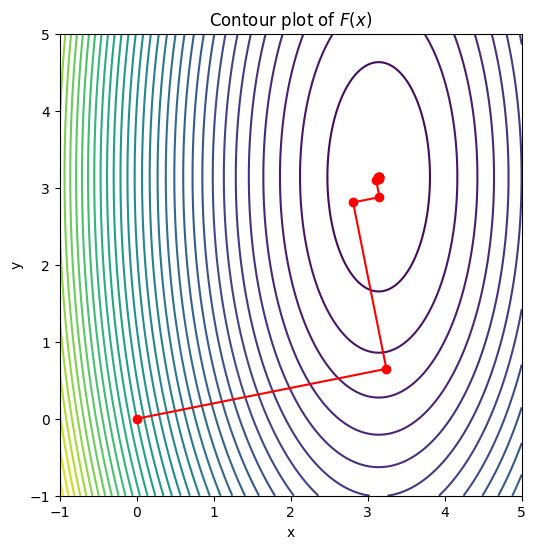

In [17]:
A = np.array([[5,0],[0,1]])
x_exact = np.array([np.pi,np.pi])
b = A@x_exact

def F(x):
	return 0.5 * np.dot(x,A@x) - np.dot(x,b)

x = np.linspace(-1, 5, 400)
y = np.linspace(-1, 5, 400)
X, Y = np.meshgrid(x, y)
Z = np.array([F(np.array([x, y])) for x, y in zip(X.flatten(), Y.flatten())]).reshape(X.shape)

fig, ax = plt.subplots(figsize=(8, 6))
ax.contour(X, Y, Z, levels=50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Contour plot of $F(x)$')
ax.set_aspect('equal', 'box')


max_steps = 10
x = np.array([0., 0.])
steps = [x]
for k in range(max_steps):
	x_new, _ = conj_gradient(A, b, x0=x, tol=1e-10, max_iter=1)
	x = x_new.copy()
	steps.append(x)

steps = np.array(steps)

ax.plot(steps[:,0], steps[:,1], 'ro-')
plt.show()